# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/albatrousse/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 87 (delta 18), reused 11 (delta 11), pack-reused 63 (from 1)
Receiving objects: 100% (87/87), 1.93 MiB | 34.08 MiB/s, done.
Resolving deltas: 100% (30/30), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


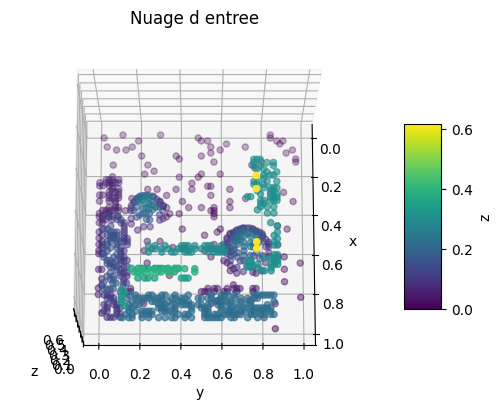

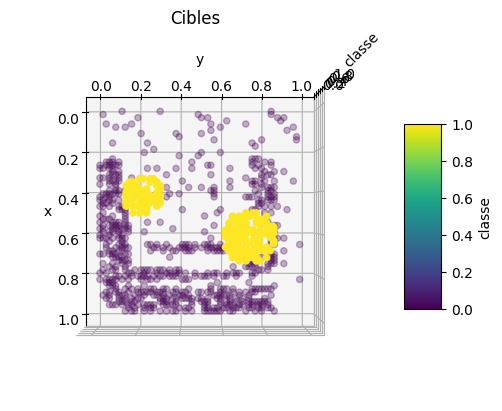

1


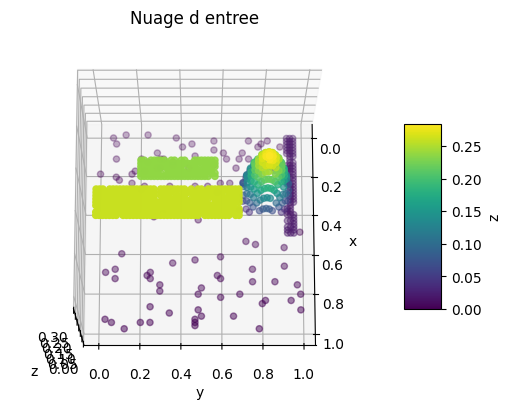

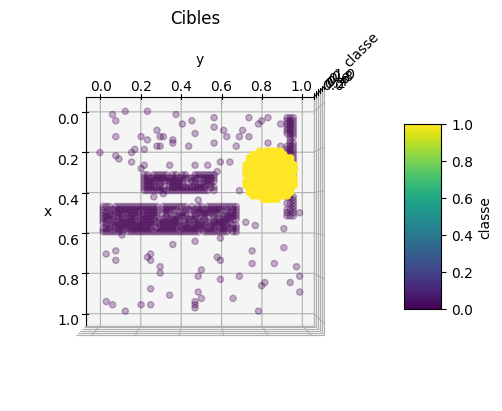

2


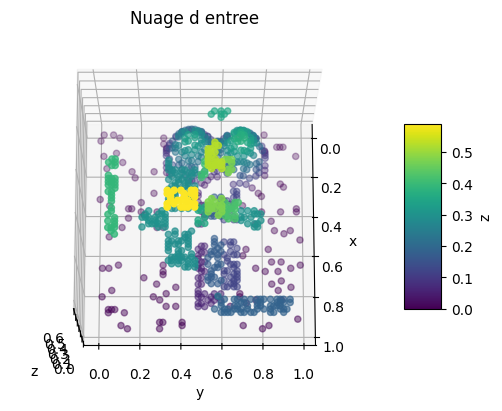

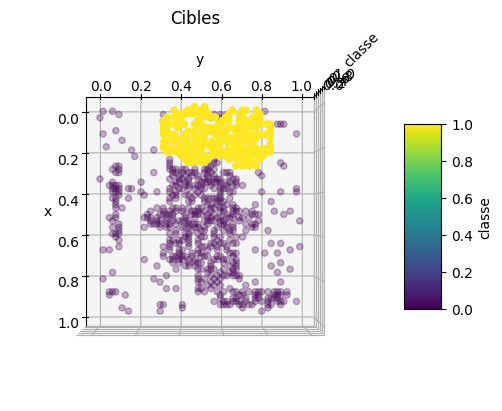

3


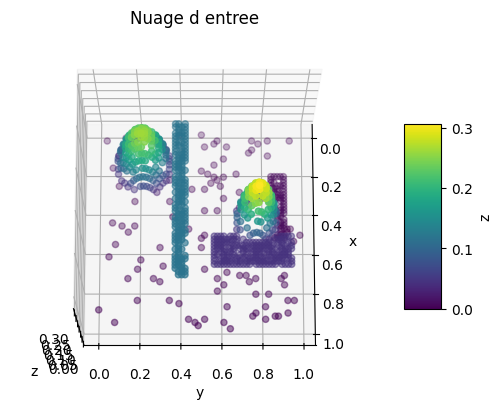

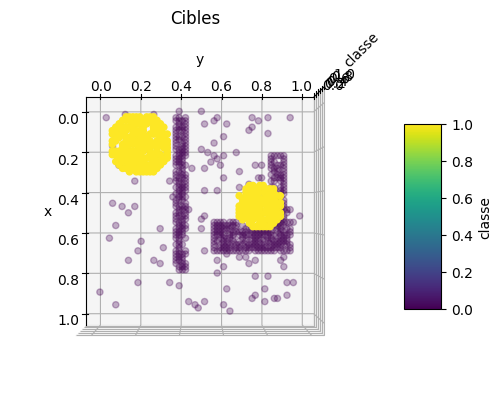

4


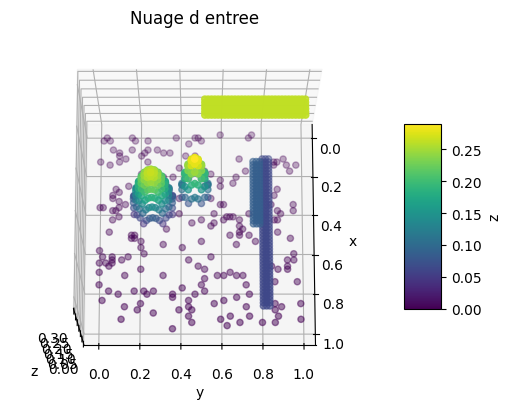

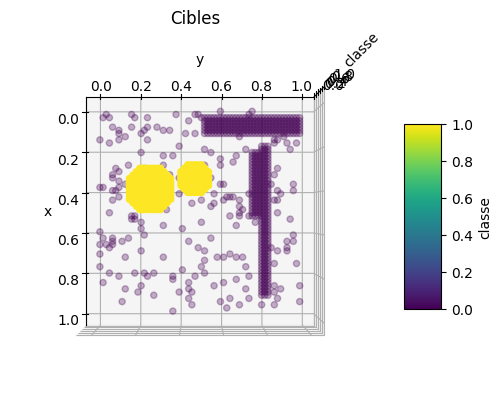

5


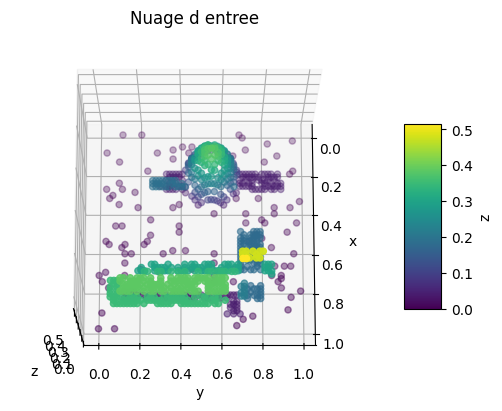

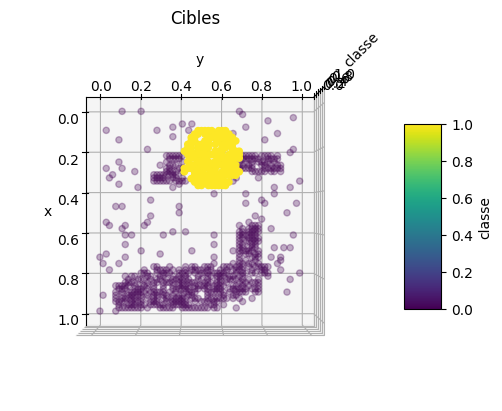

In [4]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

La variable input_points est un tenseur qui contient les coordonnées (x, y, z) de chaque point dans le nuage de points.

In [6]:
print(input_points.shape)
# Par conséquent, input_points stocke un lot de 6 nuages de points,
# avec ses cordoonées 3D et 800 points !

torch.Size([6, 3, 800])


**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

Puisqu'on échantillonne les surfaces vues du ciel en favorisant les zones d'altitude non nulles, il y a un biais dans la distribution des points. Les points seront plus denses dans les zones d'altitude élevée (toits des bâtiments et igloos) et moins denses au niveau du sol. Pour être plus précis, les points d'un nuage ne sont pas rangés dans un ordre particulier au sens d'une séquence ordonnée, mais leur distribution spatiale n'est pas uniforme.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

Les FCN et les VIT sont con_us pour les images, hors ici nos données sont des points en 3D. Il faudrait alors transformer les nuages de points en une représentation 2D qui garde un sens. Plusieurs méthodes sont possibles pour cela, nous pouvons projeter en 2D le nuage dans un angle de vue adapté ou générer plusieurs images 2D d'un meme nuage de points sous différents angles. Après transformation, un FCN ou un VIT pourrait etre utilisé pour segmenter l'image ! Puis pour visualiser l'image, il faudrait retransformé le résultat en 3D afin d'obtenir la segmentation du nuage de points original.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [14]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

La sortie du modèle PointNet, désignée par le premier tenseur du tuple renvoyé par la fonction forward, a les dimensions suivantes :

où :

* batch_size : le nombre de nuages de points traités dans le batch.
* num_points : le nombre de points dans chaque nuage (ici, 800).
* m : le nombre de classes ou d'étiquettes prédits pour chaque point (dans le cadre de segmentation sémantique, ici 2).

Comme expliqué dans le texte de recherche : "In this paper, we design a
novel type of neural network that directly consumes point
clouds, which well respects the permutation invariance of
points in the input." Inidiquant l'invariance de PointNet par rapport à l'ordre d'entrée.

In [15]:
output.shape

# Application d'une permutation aléatoire sur les points
permutation = torch.randperm(input_points.shape[1])  # Permute les points
input_points_permuted = input_points[:, permutation, :]  # Permute les points dans toutes les dimensions

# Passage des points permutés dans le modèle
output_permuted, _, _ = pointnet(input_points_permuted)

# Comparaison des sorties
print("Différence absolue entre les sorties :", torch.abs(output - output_permuted).max().item())

Différence absolue entre les sorties : 7.486310958862305


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

PointNet réalise la segmentation en extrayant d'abord des caractéristiques locales pour chaque point via un réseau partagé, ce qui garantit un traitement identique quel que soit leur ordre. Ensuite, il agrège les informations globales du nuage entier à l'aide d'une opération symétrique (max-pooling) pour capturer une représentation globale invariante à l'ordre des points. Ces caractéristiques globales sont combinées avec les caractéristiques locales de chaque point, permettant au réseau d'avoir à la fois une vision individuelle et contextuelle. Enfin, ces informations combinées servent à prédire la classe de chaque point, aboutissant à une segmentation du nuage.

Le terme "shared" signifie que les mêmes poids (paramètres) du MLP sont appliqués à tous les points du nuage. Cela garantit que l'opération est équivalente pour tous les points, quel que soit leur ordre dans la liste.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [24]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

loss_fn = torch.nn.CrossEntropyLoss().cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = output.transpose(1,2)
loss_fn(proba_pred_list, target_list.cuda())

tensor(0.7788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [25]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


# Boucle d'entraînement
for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    epoch_loss = 0.0
    correct = 0
    total = 0

    for batch in range(n_batch_per_epoch):
        # Génération des données d'entrée
        input_points, target_list, _ = gen_pointcloud(batch_size)
        input_points = input_points.cuda()
        target_list = target_list.cuda()

        # Forward pass
        outputs, _, _ = pointnet(input_points)
        proba_pred_list = outputs.transpose(1, 2)

        # Calcul de la perte
        loss = loss_fn(proba_pred_list, target_list)
        epoch_loss += loss.item()

        # Backward pass et mise à jour des poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcul de la justesse
        pred_list = proba_pred_list.max(1)[1]
        correct += (pred_list == target_list).sum().item()
        total += target_list.numel()

    accuracy = correct / total
    print(f'Loss: {epoch_loss / n_batch_per_epoch:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/200
Loss: 0.7517, Accuracy: 0.4982
Epoch 2/200
Loss: 0.7216, Accuracy: 0.5358
Epoch 3/200
Loss: 0.7156, Accuracy: 0.5056
Epoch 4/200
Loss: 0.7068, Accuracy: 0.5222
Epoch 5/200
Loss: 0.6989, Accuracy: 0.5344
Epoch 6/200
Loss: 0.6996, Accuracy: 0.5097
Epoch 7/200
Loss: 0.6947, Accuracy: 0.5315
Epoch 8/200
Loss: 0.6897, Accuracy: 0.5382
Epoch 9/200
Loss: 0.6909, Accuracy: 0.5365
Epoch 10/200
Loss: 0.6883, Accuracy: 0.5316
Epoch 11/200
Loss: 0.6843, Accuracy: 0.5543
Epoch 12/200
Loss: 0.6832, Accuracy: 0.5669
Epoch 13/200
Loss: 0.6769, Accuracy: 0.5865
Epoch 14/200
Loss: 0.6777, Accuracy: 0.5864
Epoch 15/200
Loss: 0.6748, Accuracy: 0.5812
Epoch 16/200
Loss: 0.6713, Accuracy: 0.5778
Epoch 17/200
Loss: 0.6706, Accuracy: 0.5799
Epoch 18/200
Loss: 0.6642, Accuracy: 0.5892
Epoch 19/200
Loss: 0.6651, Accuracy: 0.5914
Epoch 20/200
Loss: 0.6618, Accuracy: 0.6197
Epoch 21/200
Loss: 0.6589, Accuracy: 0.6284
Epoch 22/200
Loss: 0.6574, Accuracy: 0.6276
Epoch 23/200
Loss: 0.6579, Accuracy: 0.62

KeyboardInterrupt: 

Je n'ai pas eu le temps de faire tourner l'entrainement de PointNet

In [26]:
# Charger les poids pré-entraînés
checkpoint_path = "https://huggingface.co/nanopiero/pointnet_igloos/resolve/main/pointnet_500_ep.pth"
state_dict = torch.hub.load_state_dict_from_url(checkpoint_path)
pointnet.load_state_dict(state_dict)
pointnet.eval()

Downloading: "https://huggingface.co/nanopiero/pointnet_igloos/resolve/main/pointnet_500_ep.pth" to /root/.cache/torch/hub/checkpoints/pointnet_500_ep.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 43.5MB/s]


PointNetSegHead(
  (backbone): PointNetBackbone(
    (tnet1): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (linear1): Linear(in_features=1024, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (linear3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pool): MaxPool1d(kernel_size=800, stride=800, padding=0,

In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
